In [2]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

In [3]:
path = untar_data(URLs.ESC50, dest = 'ESC50')

In [5]:
path

Path('ESC50/master')

In [7]:
list(path.ls())

[Path('ESC50/master/requirements.txt'),
 Path('ESC50/master/LICENSE'),
 Path('ESC50/master/pytest.ini'),
 Path('ESC50/master/.github'),
 Path('ESC50/master/.circleci'),
 Path('ESC50/master/.gitignore'),
 Path('ESC50/master/esc50.gif'),
 Path('ESC50/master/meta'),
 Path('ESC50/master/tests'),
 Path('ESC50/master/audio'),
 Path('ESC50/master/README.md')]

In [8]:
(path /'audio').ls()

(#2000) [Path('ESC50/master/audio/1-84704-A-39.wav'),Path('ESC50/master/audio/1-60997-B-20.wav'),Path('ESC50/master/audio/1-96890-A-37.wav'),Path('ESC50/master/audio/2-126756-A-29.wav'),Path('ESC50/master/audio/4-181708-A-32.wav'),Path('ESC50/master/audio/4-204618-A-11.wav'),Path('ESC50/master/audio/5-182007-A-36.wav'),Path('ESC50/master/audio/3-156581-B-14.wav'),Path('ESC50/master/audio/3-197408-B-8.wav'),Path('ESC50/master/audio/3-126391-A-27.wav')...]

In [10]:
df = pd.read_csv(path / 'meta' / 'esc50.csv')
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [12]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [15]:
cfg = AudioConfig.BasicMelSpectrogram(n_fft = 512)
a2s = AudioToSpec.from_cfg(cfg)

In [16]:
auds = DataBlock(blocks = (AudioBlock, CategoryBlock),
                 get_x = ColReader('filename', pref = path / 'audio'),
                 get_y = ColReader('category'),
                 splitter = CrossValidationSplitter(fold = 1),
                 batch_tfms = [a2s]
                )

In [20]:
dbunch = auds.dataloaders(df, bs = 64)

/home/karrrrrrrr/anaconda3/envs/fastaudio/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/karrrrrrrr/anaconda3/envs/fastaudio/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


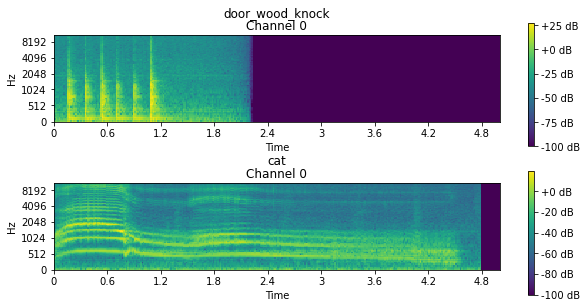

In [21]:
dbunch.show_batch(figsize = (10, 5))

In [26]:
learn = cnn_learner(dbunch, 
                    resnet50,
                    config = cnn_config(n_in = 1),
                    loss_fn = CrossEntropyLossFlat,
                    metrics = [accuracy]
                   )

In [27]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,3.812254,2.141656,0.450000,00:08


epoch,train_loss,valid_loss,accuracy,time
0,1.289199,1.570824,0.565000,00:10
1,0.879512,1.391384,0.580000,00:10
2,0.592307,1.347679,0.632500,00:10
3,0.406957,1.353067,0.637500,00:10
4,0.286659,1.284657,0.650000,00:10
5,0.194251,1.201147,0.692500,00:10
6,0.128501,1.145455,0.695000,00:10
7,0.087643,1.119839,0.697500,00:10
8,0.060836,1.100589,0.705000,00:10
9,0.043259,1.093318,0.700000,00:10
